In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import os
import gdown
import matplotlib as mpl

/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### MPL settings

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'

# this one makes the ticks into text in the exported svgs
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

## Download data

In [3]:
url_abundance_maps = "https://drive.google.com/uc?export=download&id=1Wwkd5HeddZowBTMnsSfDGfX6Z0cB3LSu"
gdown.download(url_abundance_maps,'../../../primary_data/abundance_maps.npz',quiet='False')

'../../../primary_data/abundance_maps.npz'

## Load data

In [3]:
spectrum_2D_dir = '../../../primary_data/main_mosaic_6by5/Spectrum2D_PC10/'
xray_energies_dir = '../../secondary_data/xray_energies.npz'

# load xray energies and spectra
endmember_spectra = np.load('../../../primary_data/abundance_maps.npz')['endmembers_centers']
xray_energies = np.load(xray_energies_dir)['xray_energies']

print(endmember_spectra.shape) 
print(xray_energies.shape)

(250, 11)
(250,)


In [4]:
# calculate the global average spectrum of the pre-processed data 
spectrum_2D_files = os.listdir(spectrum_2D_dir)
mean_spectrum = np.zeros((xray_energies.shape[0], len(spectrum_2D_files)))

for idx, file in enumerate(spectrum_2D_files):
    array = np.mean(np.load(os.path.join(spectrum_2D_dir, file))['spectrum_2D'], axis = 0)
    mean_spectrum[:,idx] = array
    print(str(idx+1) + ' out of ' + str(len(spectrum_2D_files)) + ' completed.', end = "\r")
    
mean_spectrum = np.mean(mean_spectrum, axis=1)

In [5]:
# define elements to plot, their x-ray lines and find the respective energy (in keV)
xray_lines = [
    ['C', 'Ka'],
    ['N', 'Ka'],
    ['O', 'Ka'],
    ['P', 'Ka'],
    ['S', 'Ka'],
    ['Cl', 'Ka'],
    ['Ca', 'Ka'],
    ['Cu', 'Ka'],
    ['Cu', 'La'],
    ['Al', 'Ka'],
    ['Fe', 'Ka'],
    ['Fe', 'La'],
    ['Os', 'Ma'],
    ['Os', 'La'],
]

for idx, xray in enumerate(xray_lines):
    xray_lines[idx].append(hs.material.elements[xray[0]].Atomic_properties.Xray_lines[xray[1]]['energy (keV)'])
print(xray_lines)

[['C', 'Ka', 0.2774], ['N', 'Ka', 0.3924], ['O', 'Ka', 0.5249], ['P', 'Ka', 2.0133], ['S', 'Ka', 2.3072], ['Cl', 'Ka', 2.6224], ['Ca', 'Ka', 3.6917], ['Cu', 'Ka', 8.0478], ['Cu', 'La', 0.9295], ['Al', 'Ka', 1.4865], ['Fe', 'Ka', 6.4039], ['Fe', 'La', 0.7045], ['Os', 'Ma', 1.9138], ['Os', 'La', 8.9108]]


[3, 4, 6, 25, 28, 32, 46, 11, 18, 80, 8, 23, 39]
['C', 'N', 'O', 'P', 'S', 'Cl', 'Ca', 'Cu La', 'Al', 'Fe', 'Fe La', 'Os Ma', 'Cd La']


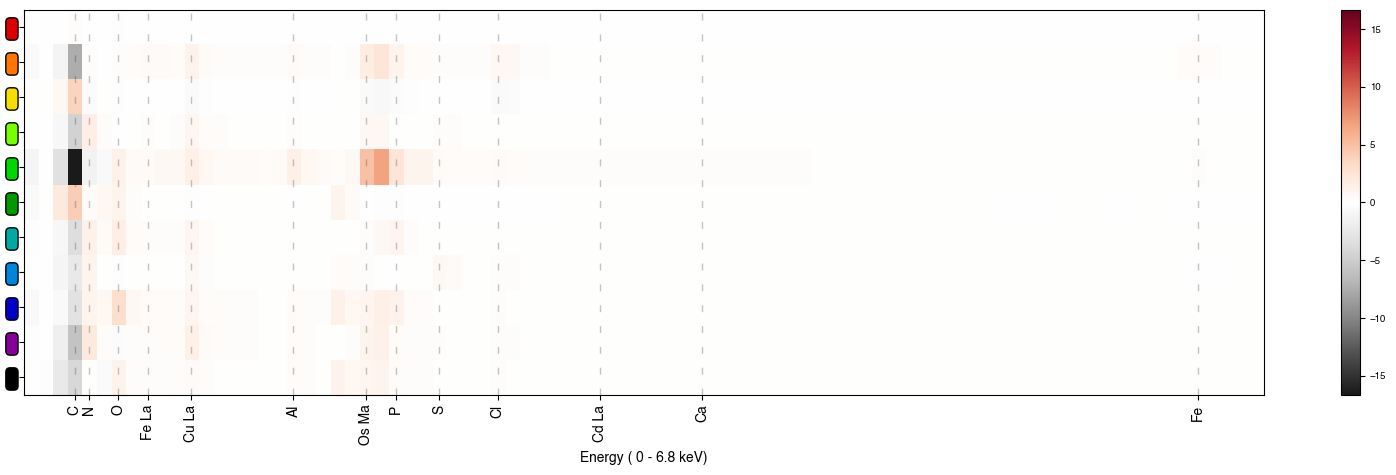

In [10]:
# generate heatmap of all endmembers
xlim = 6.8 # limited energy (keV) axis

# calculate the deviation of all endmember spectra from the average spectrum
endmember_spectra_dev = np.copy(endmember_spectra)
for i in range(endmember_spectra_dev.shape[1]):
    endmember_spectra_dev[:,i] = endmember_spectra_dev[:,i] - mean_spectrum

cmap = plt.get_cmap('nipy_spectral')
cmap_idx = np.linspace(0, 0.9, endmember_spectra_dev.shape[1])

f, ax = plt.subplots(figsize = (20,5))

dyn_range = np.sqrt(np.max(endmember_spectra_dev * endmember_spectra_dev))

hm = ax.imshow(np.transpose(endmember_spectra_dev[0:np.argmin(np.abs(xray_energies-xlim)),:]), 
          cmap = 'RdGy_r', 
          vmin = dyn_range*-1, 
          vmax = dyn_range, 
          aspect = 'auto',
          origin = 'lower')

# set yticks
yticks = []
ylabels = [] 
for idx in range(endmember_spectra_dev.shape[1]):
    yticks.append(idx)
    ylabels.append(' ')
ax.set_yticks(yticks, ylabels, size = 10)

# add bbox to yticks 
for idx in range(endmember_spectra_dev.shape[1]):
    ax.get_yticklabels()[idx].set_bbox(dict(boxstyle = 'round', facecolor = list(cmap(cmap_idx[idx]))))

# set xticks and add vertical lines at selected xray_lines
xticks = []
xlabels = []

# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    if xray[2] <= xlim:
        xticks.append(np.argmin(np.abs(xray_energies-xray[2])))
        if xray[1] == 'Ka':
            xlabels.append(xray[0])
        else:
            xlabels.append(xray[0] + ' ' + xray[1])
        plt.vlines(np.argmin(np.abs(xray_energies-xray[2])),
                   -0.5, 
                   endmember_spectra_dev.shape[1]-0.5, 
                   linestyle = (0,(5,10)), 
                   color = [0.1, 0.1, 0.1, 0.25], 
                   linewidth = 1)
print(xticks)
print(xlabels)
ax.set_xticks(xticks, xlabels, rotation = 90, size = 10)
ax.set_xlabel('Energy ( 0 - ' + str(xlim) + ' keV)')

plt.colorbar(hm, location = 'right')
#plt.savefig('../svg/figure_3C_all.svg')


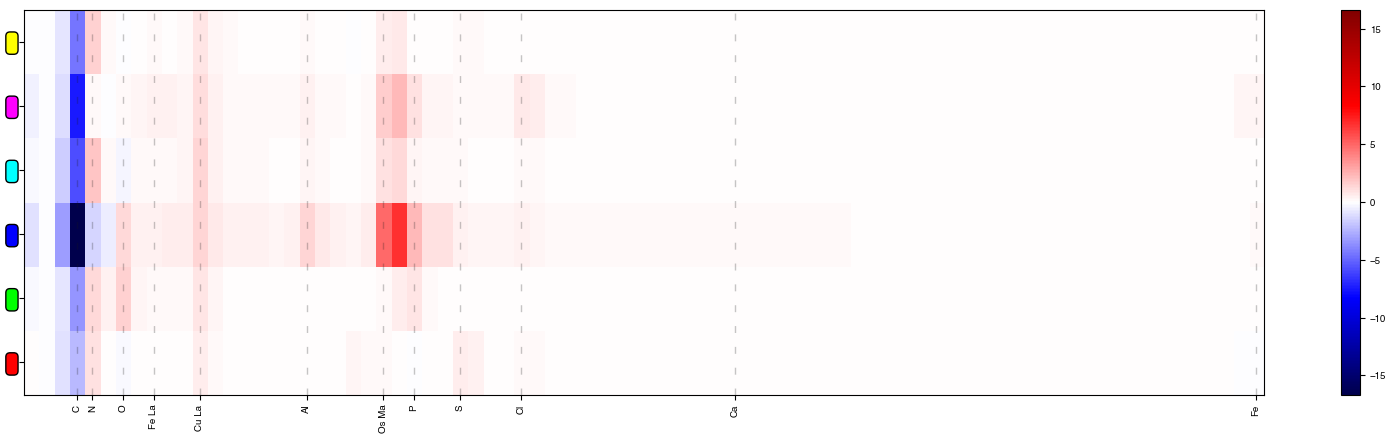

In [22]:
# generate heatmap of selected endmembers
cmap_heatmap = 'seismic' #'RdGy_r'


xlim = 6.5 # limited energy (keV) axis
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

# calculate the deviation of the selected endmember spectra from the average spectrum
endmember_spectra_dev = np.copy(endmember_spectra[:,indices])
for i in range(endmember_spectra_dev.shape[1]):
    endmember_spectra_dev[:,i] = endmember_spectra_dev[:,i] - mean_spectrum

f, ax = plt.subplots(figsize = (20,5))

dyn_range = np.sqrt(np.max(endmember_spectra_dev * endmember_spectra_dev))

hm = ax.imshow(np.transpose(endmember_spectra_dev[0:np.argmin(np.abs(xray_energies-xlim)),:]), 
          cmap = cmap_heatmap, 
          vmin = dyn_range*-1, 
          vmax = dyn_range, 
          aspect = 'auto',
          origin = 'lower')

# set yticks
yticks = []
ylabels = [] 
for idx in range(endmember_spectra_dev.shape[1]):
    yticks.append(idx)
    ylabels.append(' ')
ax.set_yticks(yticks, ylabels, size = 10)

# add bbox to yticks 
for idx in range(endmember_spectra_dev.shape[1]):
    ax.get_yticklabels()[idx].set_bbox(dict(boxstyle = 'round', facecolor = colors[idx]))

# set xticks and add vertical lines at selected xray_lines
xticks = []
xlabels = []

# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    if xray[2] <= xlim:
        xticks.append(np.argmin(np.abs(xray_energies-xray[2])))
        if xray[1] == 'Ka':
            xlabels.append(xray[0])
        else:
            xlabels.append(xray[0] + ' ' + xray[1])
        plt.vlines(np.argmin(np.abs(xray_energies-xray[2])),
                   -0.5, 
                   endmember_spectra_dev.shape[1]-0.5, 
                   linestyle = (0,(5,10)), 
                   color = [0.1, 0.1, 0.1, 0.25], 
                   linewidth = 1)
ax.set_xticks(xticks, xlabels, rotation = 90, size = 7)
#ax.set_xlabel('Energy ( 0 - ' + str(xlim) + ' keV)')

plt.colorbar(hm, location = 'right')
#plt.savefig('../svg/figure_3C_selected_%s.svg' % cmap_heatmap)


### Axis break

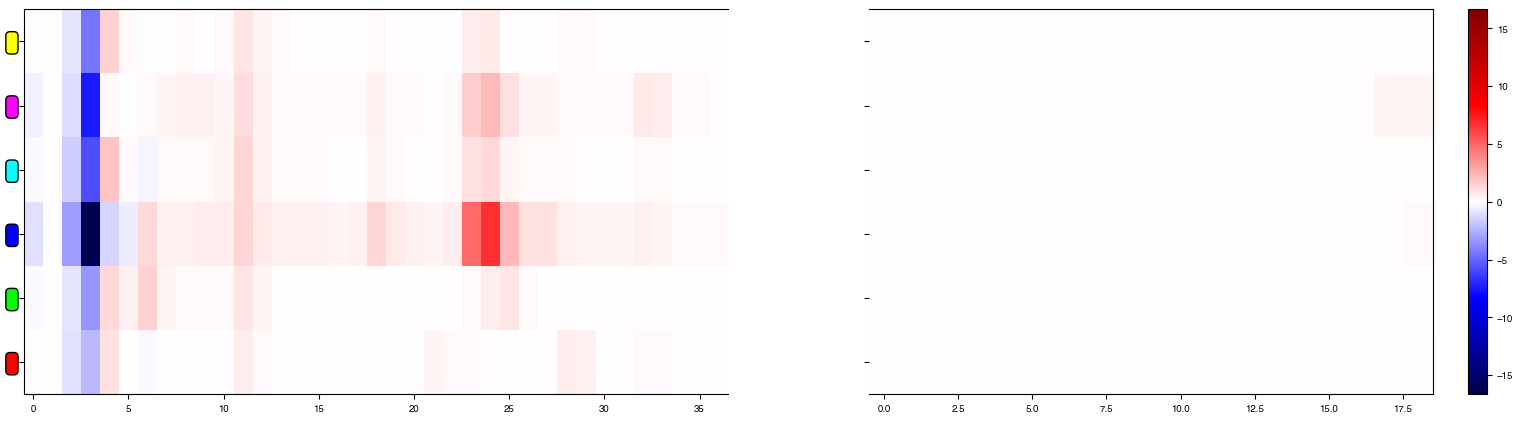

In [92]:
# generate heatmap of selected endmembers
cmap_heatmap = 'seismic' #'RdGy_r'


xlim1 = [0,3]       # limited energy (keV) axis
xlim2 = [5,6.5]


indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

# calculate the deviation of the selected endmember spectra from the average spectrum
endmember_spectra_dev = np.copy(endmember_spectra[:,indices])
for i in range(endmember_spectra_dev.shape[1]):
    endmember_spectra_dev[:,i] = endmember_spectra_dev[:,i] - mean_spectrum

f, (ax1,ax2) = plt.subplots(1,2,figsize = (20,5),sharex=False)
#f.subplots_adjust(hspace=0.05)

dyn_range = np.sqrt(np.max(endmember_spectra_dev * endmember_spectra_dev))


hm1 = ax1.imshow(np.transpose(endmember_spectra_dev[0:np.argmin(np.abs(xray_energies-xlim1[1])),:]), 
          cmap = cmap_heatmap, 
          vmin = dyn_range*-1, 
          vmax = dyn_range, 
          aspect = 'auto',
          origin = 'lower')


hm2 = ax2.imshow(np.transpose(endmember_spectra_dev[np.argmin(np.abs(xray_energies-xlim2[0])):np.argmin(np.abs(xray_energies-xlim2[1])),:]), 
          cmap = cmap_heatmap, 
          vmin = dyn_range*-1, 
          vmax = dyn_range, 
          aspect = 'auto',
          origin = 'lower')

# Limits
#ax1.set_xlim(xlim1[0], xlim1[1])  
#ax2.set_xlim(xlim2[0], xlim2[1])  


# set yticks
yticks = []
ylabels = [] 
for idx in range(endmember_spectra_dev.shape[1]):
    yticks.append(idx)
    ylabels.append(' ')


    
ax1.set_yticks(yticks, ylabels, size = 10)
ax2.set_yticks(yticks, ylabels, size = 10)





# add bbox to yticks 
for idx in range(endmember_spectra_dev.shape[1]):
    ax1.get_yticklabels()[idx].set_bbox(dict(boxstyle = 'round', facecolor = colors[idx]))
    #ax2.get_yticklabels()[idx].set_bbox(dict(boxstyle = 'round', facecolor = colors[idx]))

# set xticks and add vertical lines at selected xray_lines
xticks1 = []
xlabels1 = []
xticks2 = []
xlabels2 = []

# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    if xray[2] in xlim1:
        xticks1.append(np.argmin(np.abs(xray_energies-xray[2])))
        if xray[1] == 'Ka':
            xlabels1.append(xray[0])
        else:
            xlabels1.append(xray[0] + ' ' + xray[1])
        ax1.vlines(np.argmin(np.abs(xray_energies-xray[2])),
                   -0.5, 
                   endmember_spectra_dev.shape[1]-0.5, 
                   linestyle = (0,(5,10)), 
                   color = [0.1, 0.1, 0.1, 0.25], 
                   linewidth = 1)

        
# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    if xray[2] in xlim2:
        xticks2.append(np.argmin(np.abs(xray_energies-xray[2])))
        if xray[1] == 'Ka':
            xlabels2.append(xray[0])
        else:
            xlabels2.append(xray[0] + ' ' + xray[1])
        ax2.vlines(np.argmin(np.abs(xray_energies-xray[2])),
                   -0.5, 
                   endmember_spectra_dev.shape[1]-0.5, 
                   linestyle = (0,(5,10)), 
                   color = [0.1, 0.1, 0.1, 0.25], 
                   linewidth = 1)
        
    
        
#ax1.set_xticks(xticks1, xlabels1, rotation = 90, size = 7)
#ax2.set_xticks(xticks2, xlabels2, rotation = 90, size = 7)
#ax.set_xlabel('Energy ( 0 - ' + str(xlim) + ' keV)')


# hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
#ax1.xaxis.tick_top()
#ax1.tick_params(labeltop=False)  # don't put tick labels at the top
#ax2.xaxis.tick_bottom()



plt.colorbar(hm2, location = 'right')
#plt.savefig('../svg/figure_3C_selected_broken_%s.svg' % cmap_heatmap)

